In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import yfinance as yf
import fredapi as fa
from datetime import date, timedelta
from Sector_Exposure import Rate_Exposures
from Exposure_Report import Exposure
import numpy as np
import matplotlib.pyplot as plt
import Useful_Functions as u
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest


In [61]:
"""

MONTHLY DATA

"""


cutoff = .7

#sector_df = pd.read_csv("2006.csv", index_col="Date")

# sectors_and_rates
sector_df = pd.read_csv("sectors_and_rates.csv", index_col="Date")

#factor_df = pd.read_csv("regular_factors_and_rates.csv", index_col="Date")

train_df = sector_df[:int(len(sector_df)*cutoff)]
test_df = sector_df[int(len(sector_df)*cutoff):]

forward = 21

#exposure = Rate_Exposures(train_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")
#for_scores = Rate_Exposures(sector_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")

exposure = Rate_Exposures(train_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")
for_scores = Rate_Exposures(sector_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")

# [int(len(u.get_monthly_data(sector_df))*cutoff):]
""" Scores for testing the training set """
ry_scores_test_monthly = for_scores.monthly_scores['Real Yield']
yc_scores_test_monthly = for_scores.monthly_scores['Yield Curve']
ry_scores_test_monthly = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index > train_df.index[-1]]
yc_scores_test_monthly = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index > train_df.index[-1]]
#ry_scores_test_monthly_test = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index <= train_df.index[-1]]
#yc_scores_test_monthly_test = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index <= train_df.index[-1]]

train_results_df = exposure.mean_returns_monthly.copy()

""" Data Below is the actual data that occured, to test against training data """
actual_results_exposure = Rate_Exposures(test_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")
actual_returns = actual_results_exposure.forward_returns_monthly.iloc[:,:-2]
actual_returns = actual_returns.loc[ (actual_returns.index >= ry_scores_test_monthly.index[0]) & (actual_returns.index <= ry_scores_test_monthly.index[-1])]
actual_returns['Real Yield_scores'] = ry_scores_test_monthly
actual_returns['Yield Curve_scores'] = yc_scores_test_monthly
actual_returns['scores'] = [(i,j) for i,j in zip(actual_returns['Real Yield_scores'], actual_returns['Yield Curve_scores'])]
actual_returns = actual_returns.drop(columns = ["Real Yield_scores", 'Yield Curve_scores'])




In [62]:


""" Better version of train_results_df (above) that is used for the Baysian Updating after Predictions """
real_train_results = exposure.forward_returns_monthly.copy()
real_train_results['scores'] = [(i,j) for i,j in zip(real_train_results['Real Yield_scores'], real_train_results['Yield Curve_scores'])]
real_train_results = real_train_results.dropna()
real_train_results = real_train_results.drop(columns = ['Real Yield_scores', 'Yield Curve_scores'])



In [64]:


def closest_combos(combo, in_index = False):

    assert isinstance(combo, tuple)
    
    min_error = 100
    errors = {}

    for rates in train_results_df.index:
        
        ry_error = abs(combo[0] - rates[0])
        yc_error = abs(combo[1] - rates[1])
        error = ry_error + yc_error
         
        errors[rates] = error
        
        if error <= min_error and error > 0:
            min_error = error
    
    mins = list(filter(lambda x: errors[x]==min_error, errors))
    
    if in_index:
        mins.append(combo)
    
    if len(mins) <= 2:
        
        more_mins = list(filter(lambda x: errors[x]==min_error+1, errors))
        
        extended = list( set(mins).union(set(more_mins)) )
        
        if len(extended) <= 3:
            
            even_more_mins = list(filter(lambda x: errors[x]==min_error+2, errors))
            
            return list( set(more_mins).union(set(even_more_mins)) )
        
        return extended
    
    return mins



In [71]:

predicted_best_sector = []
predicted_worst_sector = []
exp_ret_top = []
exp_ret_bottom = []
scores = []
top_n_sectors = 1
bottom_n_sectors = 1

for num, (ry, yc) in enumerate(zip(ry_scores_test_monthly, yc_scores_test_monthly)):
    
    if ((ry, yc) == real_train_results['scores']).any():
        
        combos = closest_combos((ry, yc), True)
    else:
        combos = closest_combos((ry, yc))
    
    #top_secs = train_results_df.loc[combos].mean().sort_values()[-top_n_sectors:]
    top_secs = real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[-top_n_sectors:]
    bottom_secs = real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[:bottom_n_sectors]
    
    if len(top_secs) == 1 and u.en in top_secs.index:
        #predicted_best_sector.append([real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values().index[-2]])
        predicted_best_sector.append(real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[-top_n_sectors-1:].index.to_list())
    else:
        predicted_best_sector.append(top_secs.index.to_list())
    
    if len(bottom_secs) == 1 and u.en in bottom_secs.index:
        
        predicted_worst_sector.append(real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()[:bottom_n_sectors+1].index.to_list())
    else:
        predicted_worst_sector.append(bottom_secs.index.to_list())
    
    #print(bottom_secs.index.to_list())
    
    exp_ret_top.append(top_secs.mean())
    exp_ret_bottom.append(bottom_secs.mean())
    scores.append((ry,yc))
    
    #update_index = ry_scores_test_monthly.index[num]
    
    #if update_index <= pd.Period("2022-04"):
        #real_train_results = pd.concat([real_train_results, pd.DataFrame(actual_returns.loc[update_index]).T.drop(columns = ["SP-500"])])

big_df = pd.DataFrame(index = ry_scores_test_monthly.index)
big_df['scores'] = scores
big_df['exp_rets_top_predicted'] = exp_ret_top
big_df['exp_rets_bottom_predicted'] = exp_ret_bottom
big_df['pred_top_secs'] = predicted_best_sector
big_df['pred_bottom_secs'] = predicted_worst_sector




In [72]:


actual_secs = []
actual_bottom_secs = []
actual_ret = []
predicted_sector_performance = []
predicted_bottom_sector_performance = []
correct_sector_performance = []

for d in actual_returns.index:
    
    top_actual_secs = actual_returns.iloc[:,:-2].loc[str(d)].sort_values()
    actual_secs.append(top_actual_secs.index[-top_n_sectors:].to_list())
    actual_ret.append(top_actual_secs[-top_n_sectors:].mean())
    actual_bottom_secs.append(top_actual_secs.index[:bottom_n_sectors].to_list())
    
    predicted_sector_performance.append(actual_returns.iloc[:,:-1].loc[str(d)][list(big_df['pred_top_secs'].loc[str(d)])].mean())
    predicted_bottom_sector_performance.append(actual_returns.iloc[:,:-1].loc[str(d)][list(big_df['pred_bottom_secs'].loc[str(d)])].mean())

actual_secs = pd.Series(actual_secs, index = actual_returns.index)
actual_ret = pd.Series(actual_ret, index = actual_returns.index)
actual_bottom_secs = pd.Series(actual_bottom_secs, index = actual_returns.index)

big_df['actual_top_secs'] = actual_secs
big_df['actual_bottom_secs'] = actual_bottom_secs
big_df['actual_top_rets'] = actual_ret
big_df = big_df.dropna()



In [73]:


correct_sectors = []
mean_squared_error_return = []
return_error_regular = []

for pred, act in zip(big_df['pred_top_secs'], big_df['actual_top_secs']):
    sect = set(pred).intersection(set(act))
    correct_sectors.append(len(sect))
    

for pred, act in zip(big_df['exp_rets_top_predicted'], big_df['actual_top_rets']):
    
    mean_squared_error_return.append((pred-act)**2)
    return_error_regular.append(pred-act) 
    
big_df['correctly_chosen_sectors'] = correct_sectors
#big_df['correctly_chosen_sectors_above_market'] = correct_sectors_above_market
big_df['predicted_sector_performance'] = predicted_sector_performance
big_df['predicted_bottom_sector_performance'] = predicted_bottom_sector_performance
#big_df['correct_sector_performance'] = actual_results['actual_rets']
big_df['mean_squared_error_return_prediction'] = mean_squared_error_return
big_df['return_error_regular'] = return_error_regular
big_df = big_df.dropna()


In [74]:



big_df.correctly_chosen_sectors.mean()



0.14285714285714285

In [75]:


big_df.predicted_sector_performance.loc[ big_df.correctly_chosen_sectors == 1].mean()



0.04483636173255723

In [76]:


big_df.predicted_sector_performance.mean()



0.0062506188058530105

In [77]:

#big_df.correctly_chosen_sectors.plot()

mean_outperform_30_days = big_df.predicted_sector_performance.mean()
mean_yearly_outperformance = mean_outperform_30_days * ((252 - forward)/forward)
#(big_df.predicted_sector_performance > 0.0).value_counts()
mean_yearly_outperformance



0.06875680686438311

0.07500742567023612

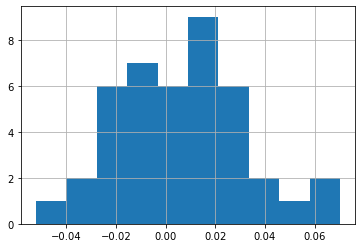

In [78]:


big_df.predicted_sector_performance.hist()
big_df.predicted_sector_performance.sum() / (len(big_df) / 12)



In [36]:


big_df.sort_values(by = 'predicted_sector_performance')



,scores,exp_rets_top_predicted,exp_rets_bottom_predicted,pred_top_secs,pred_bottom_secs,actual_top_secs,actual_bottom_secs,actual_top_rets,correctly_chosen_sectors,predicted_sector_performance,predicted_bottom_sector_performance,mean_squared_error_return_prediction,return_error_regular
2020-02,"(-2.0, -1.0)",0.003250,-0.006141,[Technology],[Utilities],[Consumer Staples],[Energy],-0.121604,0,-0.179461,-0.170947,0.015588,0.124853
2022-04,"(5.0, -1.0)",0.012131,-0.019680,[Technology],"[Energy, Telecomm]",[Energy],[Consumer Discretionary],0.056884,0,-0.087858,-0.022567,0.002003,-0.044754
2019-07,"(-3.0, -0.0)",0.005429,-0.006643,[Consumer Discretionary],[Utilities],[Real Estate],[Energy],0.026681,0,-0.049805,0.010708,0.000452,-0.021252
2022-01,"(3.0, -2.0)",0.023790,-0.012586,[Utilities],[Materials],[Energy],[Telecomm],0.091571,0,-0.028737,-0.037631,0.004594,-0.067782
2021-12,"(0.0, -3.0)",0.014588,-0.027889,[Health Care],[Real Estate],[Energy],[Consumer Discretionary],0.141247,0,-0.019714,-0.024808,0.016042,-0.126659
2019-04,"(-2.0, 0.0)",0.005429,-0.006643,[Consumer Discretionary],[Utilities],[Consumer Staples],[Energy],0.011064,0,-0.018856,0.007540,0.000032,-0.005635
2022-05,"(4.0, -1.0)",0.012131,-0.019680,[Technology],"[Energy, Telecomm]",[Energy],[Consumer Staples],0.128466,0,-0.016608,0.060691,0.013534,-0.116336
2020-03,"(-0.0, 5.0)",0.006150,-0.010150,[Financials],"[Energy, Telecomm]",[Health Care],[Financials],0.094578,0,-0.001094,0.062078,0.007819,-0.088428
2020-08,"(-2.0, 1.0)",0.005850,-0.007855,[Consumer Discretionary],"[Energy, Real Estate]",[Materials],[Energy],0.031009,0,0.003836,-0.064923,0.000633,-0.025159
2020-06,"(-2.0, 2.0)",0.014209,-0.007949,[Utilities],[Materials],[Consumer Discretionary],[Energy],0.070635,0,0.004621,0.056673,0.003184,-0.056426


In [37]:


(big_df.correctly_chosen_sectors > 0).value_counts()



False    39
True      3
Name: correctly_chosen_sectors, dtype: int64

In [39]:


#big_df.actual_rets.sum() - big_df.predicted_sector_performance.sum()

mean_underperform_30_days = big_df.predicted_bottom_sector_performance.mean() 
mean_yearly_underperformance = mean_underperform_30_days * ((252 - forward)/forward)
mean_yearly_underperformance

big_df.predicted_bottom_sector_performance.sum() / (len(big_df) / 12)

mean_underperform_30_days

0.022055525423247197

In [375]:


#big_df.sort_values(by = "predicted_sector_performance")

#big_df


<AxesSubplot:xlabel='Date'>

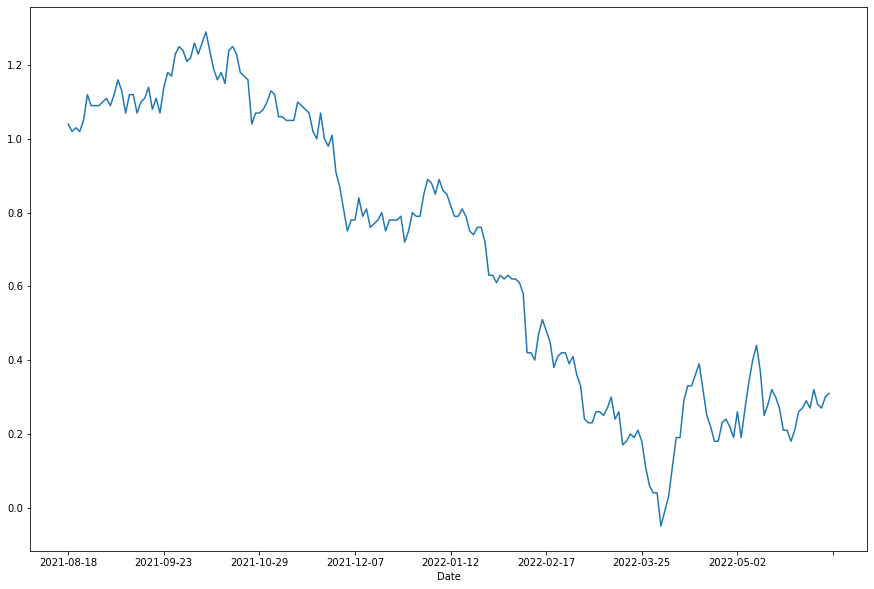

In [60]:



actual_returns.loc['2022-04']

combos = closest_combos((5,-1))


# .mean().sort_values()
# ['Aerospace']

real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)].mean().sort_values()
#real_train_results.iloc[:,:-1].loc[real_train_results['scores'].isin(combos)][u.ut]

#combos

#sector_df['Real Yield'][-200:].plot(figsize = (15,10))
sector_df['Yield Curve'][-200:].plot(figsize = (15,10))


In [6]:

new_thing = pd.DataFrame()
new_rets = sector_df.copy()
new_rets.index = pd.to_datetime(new_rets.index)



In [7]:


actual_secs = []
actual_bottom_secs = []
actual_ret = []
predicted_sector_performance = []
predicted_bottom_sector_performance = []
correct_sector_performance = []

for d in actual_returns.index:
    
    dex = new_rets.loc[ (new_rets.index.month == d.month) & (new_rets.index.year == d.year)].index[0]

    if len(new_rets.loc[dex:]) >= forward:
        
        top_actual_secs = new_rets.loc[dex:].iloc[0:forward].pct_change().cumsum().iloc[-1][:-3].sort_values()
        actual_secs.append(top_actual_secs.index[-top_n_sectors:].to_list())
        actual_bottom_secs.append(top_actual_secs.index[:top_n_sectors].to_list())
        actual_ret.append(top_actual_secs[-top_n_sectors:].mean())
    
        predicted_sector_performance.append(top_actual_secs[list(big_df['pred_top_secs'].loc[str(d)])].mean())
        predicted_bottom_sector_performance.append(top_actual_secs[list(big_df['pred_bottom_secs'].loc[str(d)])].mean())

actual_secs = pd.Series(actual_secs, index = actual_returns.index)
actual_bottom_secs = pd.Series(actual_bottom_secs, index = actual_returns.index)
actual_ret = pd.Series(actual_ret, index = actual_returns.index)


new_thing['actual_top_secs'] = actual_secs
new_thing['pred_top_secs'] = big_df.pred_top_secs
new_thing['actual_bottom_secs'] = actual_bottom_secs
new_thing['pred_bottom_secs'] = big_df.pred_bottom_secs
new_thing['actual_rets'] = actual_ret
new_thing['predicted_sector_performance'] = predicted_sector_performance
new_thing['predicted_bottom_sector_performance'] = predicted_bottom_sector_performance
new_thing = new_thing.dropna()



In [8]:


new_thing



,actual_top_secs,pred_top_secs,actual_bottom_secs,pred_bottom_secs,actual_rets,predicted_sector_performance,predicted_bottom_sector_performance
2018-12,[Telecomm],[Health Care],[Energy],[Real Estate],-0.061573,-0.105903,-0.105867
2019-01,[Real Estate],[Consumer Discretionary],[Utilities],[Utilities],0.116144,0.079234,0.031378
2019-02,[Technology],[Consumer Discretionary],[Real Estate],[Utilities],0.065722,0.033886,0.039978
2019-03,[Real Estate],[Technology],[Financials],[Utilities],0.046565,0.030725,0.018633
2019-04,[Telecomm],[Consumer Discretionary],[Health Care],[Utilities],0.072206,0.045636,-0.000406
2019-05,[Utilities],[Consumer Discretionary],[Technology],[Utilities],-0.004492,-0.058598,-0.004492
2019-06,[Technology],[Health Care],[Real Estate],"[Energy, Telecomm]",0.105864,0.060452,0.072540
2019-07,[Technology],[Consumer Discretionary],[Energy],[Industrials],0.005220,-0.024178,-0.014317
2019-08,[Real Estate],[Technology],[Energy],[Utilities],0.035550,-0.025634,0.029206
2019-09,[Financials],[Technology],[Real Estate],"[Energy, Utilities]",0.055347,0.027880,0.031869


<AxesSubplot:>

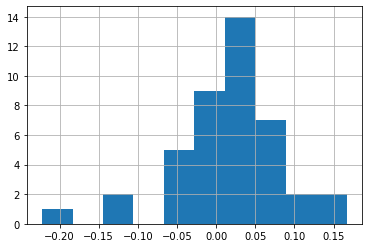

In [11]:



new_thing.predicted_sector_performance.hist()




In [14]:

#  * ((252 - forward)/forward)

#new_thing.predicted_sector_performance.mean() * (252/forward)

rets_top = []
#rets_bottom = []

for n in range(100000):
    
    new_top = 0
    #new_bottom = 0
    for i in range(12):
        
        new_top += np.random.choice(new_thing.predicted_sector_performance.to_list())
        #new_bottom += random.choice(new_thing.predicted_bottom_sector_performance.to_list())
    
    new_top += np.random.choice(new_thing.predicted_sector_performance.to_list())*.6
    
    rets_top.append(new_top)
    #rets_bottom.append(random.choice(new_thing.predicted_bottom_sector_performance.to_list()))

rets_top = pd.Series(rets_top)
#rets_bottom = pd.Series(rets_bottom)



<AxesSubplot:>

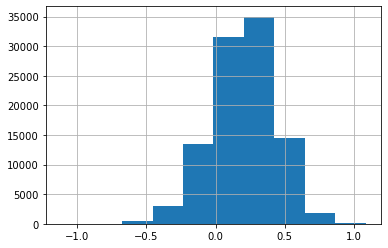

In [15]:



rets_top.hist()




In [18]:



len(rets_top.loc[rets_top > 0]) / len(rets_top)




0.81472

In [37]:


exposure = Exposure(sector_df, 252, 20, ['Real Yield', 'Yield Curve'], "SP-500")



In [55]:


ok = normaltest(exposure.total_return_all_combos[(1,1)])


ok[1] < .05


array([ True, False,  True,  True, False, False, False, False, False,
       False,  True])

In [64]:


combs = {}


for c in exposure.total_return_all_combos:
    overall = exposure.total_return_all_combos[(1,1)]
    means = overall.mean()
    stds = overall.std()

    confidence = pd.Series([(round(i,3),round(j,3), normaltest(overall[means.index[num]])[1] < .05) for num, (i,j) in enumerate(zip(means - stds*2, means + stds*2, ))], index = means.index)

    combs[c] = confidence



In [68]:


validity = pd.DataFrame(combs).T



In [72]:



validity.loc[(4,-4)]



Materials                   (-0.06, 0.052, True)
Industrials               (-0.032, 0.029, False)
Consumer Discretionary     (-0.032, 0.034, True)
Consumer Staples           (-0.046, 0.039, True)
Health Care               (-0.033, 0.043, False)
Financials                (-0.053, 0.052, False)
Technology                (-0.028, 0.039, False)
Telecomm                  (-0.068, 0.044, False)
Utilities                 (-0.068, 0.059, False)
Real Estate                (-0.061, 0.06, False)
Energy                       (-0.1, 0.088, True)
Name: (4.0, -4.0), dtype: object

In [37]:

#big_df.predicted_sector_performance.mean() * ((252 - forward)/forward)

new_thing['off_by'] = (new_thing.actual_rets - new_thing.predicted_sector_performance)**2


new_thing.sort_values(by="off_by")

,actual_top_secs,pred_top_secs,actual_bottom_secs,pred_bottom_secs,actual_rets,predicted_sector_performance,predicted_bottom_sector_performance,off_by
2019-02,[Technology],[Technology],[Real Estate],"[Energy, Telecomm]",0.065722,0.065722,0.019880,0.000000
2020-06,[Technology],[Technology],[Utilities],"[Energy, Real Estate]",0.041683,0.041683,-0.045214,0.000000
2021-11,[Technology],[Technology],[Energy],"[Energy, Industrials]",0.043659,0.043659,-0.056218,0.000000
2021-06,[Technology],[Technology],[Materials],"[Energy, Telecomm]",0.065615,0.065615,0.016629,0.000000
2019-06,[Technology],[Technology],[Real Estate],"[Energy, Materials]",0.105864,0.105864,0.075154,0.000000
2019-11,[Health Care],[Health Care],[Real Estate],[Utilities],0.041715,0.041715,-0.028486,0.000000
2019-10,[Health Care],[Health Care],[Utilities],[Utilities],0.052936,0.052936,-0.017690,0.000000
2021-07,[Utilities],[Technology],[Energy],"[Energy, Financials]",0.039390,0.037992,-0.044132,0.000002
2022-03,[Materials],[Consumer Discretionary],[Consumer Staples],[Real Estate],0.091330,0.085029,0.063004,0.000040
2019-07,[Technology],[Consumer Staples],[Energy],"[Energy, Industrials]",0.005220,-0.002991,-0.023020,0.000067


<AxesSubplot:>

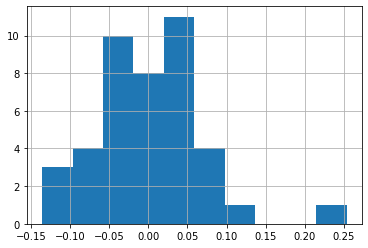

In [40]:


# * ((252 - forward)/forward)

new_thing.predicted_bottom_sector_performance.hist()



In [41]:



new_thing.sort_values(by = "predicted_bottom_sector_performance")




,actual_top_secs,pred_top_secs,actual_bottom_secs,pred_bottom_secs,actual_rets,predicted_sector_performance,predicted_bottom_sector_performance,off_by
2022-04,[Consumer Staples],"[Utilities, Energy]",[Telecomm],[Consumer Discretionary],0.012489,-0.039122,-0.135843,0.002664
2020-03,[Health Care],"[Technology, Energy]",[Energy],[Utilities],-0.103614,-0.263412,-0.116050,0.025535
2018-12,[Telecomm],[Health Care],[Energy],[Real Estate],-0.061573,-0.105903,-0.105867,0.001965
2020-02,[Real Estate],[Technology],[Energy],"[Energy, Industrials]",-0.015439,-0.029553,-0.093902,0.000199
2019-05,[Utilities],[Consumer Staples],[Technology],"[Energy, Industrials]",-0.004492,-0.017606,-0.068873,0.000172
2021-09,[Energy],[Consumer Discretionary],[Utilities],[Telecomm],0.122360,-0.010760,-0.068292,0.017721
2022-02,[Energy],[Utilities],[Telecomm],[Financials],0.039451,-0.017785,-0.064550,0.003276
2021-11,[Technology],[Technology],[Energy],"[Energy, Industrials]",0.043659,0.043659,-0.056218,0.000000
2022-01,[Energy],[Utilities],[Consumer Discretionary],[Materials],0.146183,-0.023468,-0.056100,0.028781
2021-02,[Energy],"[Financials, Energy]",[Utilities],[Utilities],0.218309,0.173813,-0.049894,0.001980


In [391]:
"""

MONTHLY DATA FOR FACTORS

"""

cutoff = .7

factor_df = pd.read_excel("factors_and_scores.xlsx", index_col="Date")

factor_train = factor_df[:int(len(factor_df)*cutoff)]
factor_test = factor_df[int(len(factor_df)*cutoff):]

#exposure = Rate_Exposures(train_df, 252, forward, ['Real Yield', 'Yield Curve'], "SP-500")
for_scores = Rate_Exposures(sector_df, 252, forward, ['Real Yield', 'Yield Curve'])

# [int(len(u.get_monthly_data(sector_df))*cutoff):]
ry_scores_test_monthly = for_scores.monthly_scores['Real Yield']
yc_scores_test_monthly = for_scores.monthly_scores['Yield Curve']
ry_scores_test_monthly = ry_scores_test_monthly.loc[ ry_scores_test_monthly.index > train_df.index[-1]]
yc_scores_test_monthly = yc_scores_test_monthly.loc[ yc_scores_test_monthly.index > train_df.index[-1]]


train_results_df = u.get_monthly_data(factor_train).copy()
train_results_df["ry_scores"] = round(train_results_df["ry_scores"], 0)
train_results_df["yc_scores"] = round(train_results_df["yc_scores"], 0)
#train_results_df

#rys = [i[0] for i in train_results_df.index]
#ycs = [i[1] for i in train_results_df.index]



In [296]:


buys = []
pred_above_market = []
exp_ret = []
top_n_sectors = 2

rates = [(i,j) for i,j in zip(train_results_df.ry_scores, train_results_df.yc_scores)]

for num, (ry, yc) in enumerate(zip(ry_scores_test_monthly, ry_scores_test_monthly)):
    
    if (ry, yc) in rates:
        
        ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
        buys.append(ok)
        
        exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].mean())        
    
    elif ry in rys and yc not in ycs:
        
        up_yc = yc
        down_yc = yc
        
        while (ry, up_yc) not in rates and (ry, down_yc) not in rates:
            
            up_yc += 1
            down_yc -= 1
        
        if (ry, up_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].mean())
            
        elif (ry, down_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(ry,down_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].mean())        
    
    elif ry not in rys and yc in ycs:

        up_ry = ry
        down_ry = ry
        
        while (up_ry, yc) not in rates and (down_ry, yc) not in rates:
            
            up_ry += 1
            down_ry -= 1
        
        if (up_ry, yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(up_ry,yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].mean())
            
        elif (down_ry, yc) in rates:
            
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(down_ry,yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == yc)].mean().sort_values()[-top_n_sectors:].mean())
            

    else:
        
        up_yc = yc
        down_yc = yc
        up_ry = ry
        down_ry = ry
        
        while ((up_ry, up_yc) not in rates and (down_ry, down_yc) not in rates and 
               (up_ry, down_yc) not in rates and (down_ry, up_yc) not in rates):
            
            up_yc += 1
            down_yc -= 1
            up_ry += 1
            down_ry -= 1
        
        if (up_ry, up_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.loc[(up_ry, up_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(up_ry, up_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].mean())
            
        elif (down_ry, down_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.loc[(down_ry, down_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(down_ry, down_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == down_ry)].mean().sort_values()[-top_n_sectors:].mean())

        
        elif (up_ry, down_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == down_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.iloc[:,:-2].loc[(up_ry, down_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(up_ry, down_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == up_ry) & (train_results_df.yc_scores == down_ry)].mean().sort_values()[-top_n_sectors:].mean())

        elif (down_ry, up_yc) in rates:
            ok = set(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].index.to_list())
            #ok = set(train_results_df.loc[(down_ry, up_yc)].sort_values()[-top_n_sectors:].index.to_list())
            buys.append(ok)
            #exp_ret.append(train_results_df.loc[(down_ry, up_yc)].sort_values()[-top_n_sectors:].mean())
            exp_ret.append(train_results_df.iloc[:,:-2].loc[(train_results_df.ry_scores == down_ry) & (train_results_df.yc_scores == up_yc)].mean().sort_values()[-top_n_sectors:].mean())
 
big_df = pd.DataFrame(index = ry_scores_test_monthly.index)
big_df['exp_rets_predicted'] = exp_ret
big_df['pred_top_secs'] = buys



In [310]:

factor_test = u.get_monthly_data(factor_test.iloc[:,:-2])

factor_test = factor_test.loc[ (factor_test.index >= "2018-11") & (factor_test.index <= "2021-11")]


In [315]:


actual_returns = factor_test



In [313]:

actual_secs = []
actual_secs_above_market = []
actual_ret = []
predicted_sector_performance = []
correct_sector_performance = []

for d in actual_returns.index:
    
    #print( big_df['pred_top_secs'])

    ok = set(actual_returns.loc[str(d)].sort_values().index[-top_n_sectors:].to_list())
    
    #set(train_results_df.loc[(ry,yc)].loc[train_results_df.loc[(ry,yc)] > 0.0].index.to_list())
    #ok_cool = set(actual_returns.loc[str(d)].loc[actual_returns.loc[str(d)] > 0.0].index.to_list())
    actual_secs.append(ok)
    #actual_secs_above_market.append(ok_cool)
    
    actual_ret.append(actual_returns.loc[str(d)].sort_values()[-top_n_sectors:].mean())
    
    
    #if d in expected_results.index:
    predicted_sector_performance.append(actual_returns.loc[str(d)][list(big_df['pred_top_secs'].loc[str(d)])].mean())


actual_secs = pd.Series(actual_secs, index = actual_returns.index)
actual_ret = pd.Series(actual_ret, index = actual_returns.index)

#actual_results = pd.DataFrame()
big_df['actual_secs'] = actual_secs
big_df['actual_rets'] = actual_ret
big_df = big_df.dropna()


In [317]:

correct_sectors = []
got_one_of_top_2_sectors = []
correct_sectors_above_market = []
mean_squared_error_return = []
return_error_regular = []

for pred, act in zip(big_df['pred_top_secs'], big_df['actual_secs']):
    
    sect = pred.intersection(act)
    correct_sectors.append(len(sect))
    
    if list(pred)[-1] == list(act)[-1]:
        got_one_of_top_2_sectors.append(1)
    else:
        got_one_of_top_2_sectors.append(0)
    
for pred, act in zip(big_df['exp_rets_predicted'], big_df['actual_rets']):
    
    mean_squared_error_return.append((pred-act)**2)
    return_error_regular.append(pred-act) 


correct_sectors = pd.Series(correct_sectors, index = big_df['exp_rets_predicted'].index)
got_one_of_top_2_sectors = pd.Series(got_one_of_top_2_sectors, index = big_df['exp_rets_predicted'].index)
mean_squared_error_return = pd.Series(mean_squared_error_return, index = big_df['exp_rets_predicted'].index)
return_error_regular = pd.Series(return_error_regular, index = big_df['exp_rets_predicted'].index)

big_df['correctly_chosen_sectors'] = correct_sectors
#big_df['correctly_chosen_sectors_above_market'] = correct_sectors_above_market
big_df['predicted_sector_performance'] = predicted_sector_performance
#big_df['correct_sector_performance'] = actual_results['actual_rets']
big_df['mean_squared_error_return_prediction'] = mean_squared_error_return
big_df['return_error_regular'] = return_error_regular

big_df = big_df.dropna()



In [323]:


big_df



,exp_rets_predicted,pred_top_secs,actual_secs,actual_rets,correctly_chosen_sectors,predicted_sector_performance,mean_squared_error_return_prediction,return_error_regular
2018-11,0.114544,"{QUALITY, CASH_TO_ASSETS}","{QUALITY, CASH_TO_ASSETS}",0.117929,2,0.117929,0.000011,-0.003385
2018-12,0.087087,"{QUALITY, CASH_TO_ASSETS}","{QUALITY, CASH_TO_ASSETS}",0.063237,2,0.063237,0.000569,0.023850
2019-01,0.054267,"{QUALITY, MOMENTUM}","{QUALITY, MOMENTUM}",0.066521,2,0.066521,0.000150,-0.012254
2019-02,0.064551,"{MOMENTUM, BOOK_TO_PRICE}","{QUALITY, MOMENTUM}",0.111022,1,-0.021956,0.002160,-0.046471
2019-03,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{QUALITY, MOMENTUM}",0.215252,0,-0.268332,0.011589,-0.107652
2019-04,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{QUALITY, MOMENTUM}",0.238507,0,-0.312435,0.017137,-0.130907
2019-05,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{QUALITY, CASH_TO_ASSETS}",0.184012,0,-0.224202,0.005839,-0.076411
2019-06,0.205168,"{QUALITY, MOMENTUM}","{SIZE, CASH_TO_ASSETS}",0.148375,0,-0.021055,0.003225,0.056793
2019-07,0.107600,"{DEFAULT, BOOK_TO_PRICE}","{SIZE, CASH_TO_ASSETS}",0.205837,0,-0.104863,0.009650,-0.098236
2019-08,0.205168,"{QUALITY, MOMENTUM}","{SIZE, CASH_TO_ASSETS}",0.239083,0,-0.027407,0.001150,-0.033916


In [322]:



big_df.predicted_sector_performance




2018-11    0.117929
2018-12    0.063237
2019-01    0.066521
2019-02   -0.021956
2019-03   -0.268332
2019-04   -0.312435
2019-05   -0.224202
2019-06   -0.021055
2019-07   -0.104863
2019-08   -0.027407
2019-09   -0.065883
2019-10   -0.048110
2019-11   -0.048569
2019-12   -0.052217
2020-01    0.143324
2020-02    0.252584
2020-03   -0.016995
2020-04   -0.423995
2020-05    0.509024
2020-06    0.409819
2020-07   -0.267421
2020-08    0.400471
2020-09    0.052345
2020-10    0.077180
2020-11    0.131182
2020-12    0.161162
2021-01    0.188832
2021-02    0.018300
Freq: M, Name: predicted_sector_performance, dtype: float64